In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
!pip install spectral
import spectral as spy
import matplotlib.patches as mpatches

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 6.9 MB/s eta 0:00:00


In [2]:
def hypermnf(cube, numComponents, mean_centered=True):
    h, w, channels = cube.shape
    cube = cube.reshape(h * w, channels)
    
    if mean_centered:
        u = np.mean(cube, axis=0)
        cube -= u

    V = np.diff(cube, axis=0)
    V = np.cov(V, rowvar=False)
    
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=numComponents, svd_solver='full')
    reduced_cube = pca.fit_transform(cube)
    
    return reduced_cube.reshape(h, w, numComponents)


In [3]:
# Main script execution
datafile = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou.bsq'
hdrfile = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou.hdr'

In [4]:
# Load the hyperspectral image using spectral library
hcube = spy.open_image(hdrfile)
img = hcube.load().astype(np.float64)

# # Exclude the last band if it contains NaN values
# if np.isnan(img[:, :, -1]).any():
#     img = img[:, :, :-1]

# Preprocess the image (e.g., using MNF/PCA for dimensionality reduction)
img = img[:, :, :270]
numComponents = 10  # Reduce to 10 components for clustering
reduced_img = hypermnf(img, numComponents)

In [5]:
# Reshape image for clustering
h, w, _ = reduced_img.shape
img_reshaped = reduced_img.reshape(-1, numComponents)


In [6]:
gt_file = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou_gt.bsq'
gt_hdr = '/kaggle/input/whu-hi-longkou/WHU-Hi-LongKou_gt.hdr'

# Load the ground truth using spectral library
gt_cube = spy.open_image(gt_hdr)
ground_truth = gt_cube.load().astype(np.int32)  # Assuming labels are integers


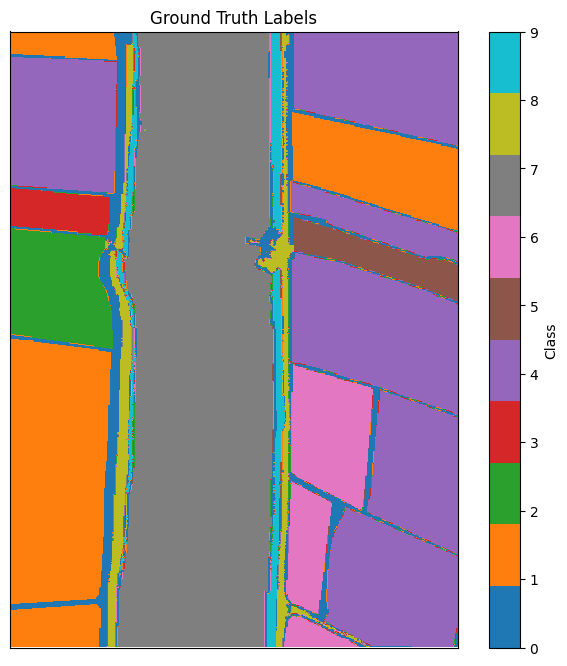

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(ground_truth, cmap='tab10')
plt.title('Ground Truth Labels')
plt.colorbar(label='Class')
plt.xticks([])
plt.yticks([])
plt.show()


In [8]:
# Apply K-means clustering
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans_labels = kmeans.fit_predict(img_reshaped)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
# Apply Gaussian Mixture Model for clustering
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=0)
gmm_labels = gmm.fit_predict(img_reshaped)

In [10]:
# Reshape the cluster labels to the original image shape
kmeans_image = kmeans_labels.reshape(h, w)
gmm_image = gmm_labels.reshape(h, w)

In [11]:
# # Define class names (optional)
# classNames = [f'class {i+1}' for i in range(num_clusters)]


In [12]:
# # Plot the results for comparison
# fig, ax = plt.subplots(1, 2, figsize=(15, 7))


In [13]:
# # K-means result
# ax[0].imshow(kmeans_image, cmap='tab10')
# ax[0].set_title('K-means Clustering')
# ax[0].set_aspect('equal', adjustable='box')
# ax[0].set_xticks([])
# ax[0].set_yticks([])

In [14]:
# # GMM result
# ax[1].imshow(gmm_image, cmap='tab10')
# ax[1].set_title('Gaussian Mixture Model Clustering')
# ax[1].set_aspect('equal', adjustable='box')
# ax[1].set_xticks([])
# ax[1].set_yticks([])

In [15]:
# # Create dummy patches for legend
# legend_patches = [mpatches.Patch(color=plt.cm.tab10(i), label=classNames[i]) for i in range(num_clusters)]

In [16]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Flatten ground truth and clustering results for evaluation
gt_labels_flat = ground_truth.ravel()
kmeans_labels_flat = kmeans_image.ravel()
gmm_labels_flat = gmm_image.ravel()

# Compute metrics
ari_kmeans = adjusted_rand_score(gt_labels_flat, kmeans_labels_flat)
nmi_kmeans = normalized_mutual_info_score(gt_labels_flat, kmeans_labels_flat)

ari_gmm = adjusted_rand_score(gt_labels_flat, gmm_labels_flat)
nmi_gmm = normalized_mutual_info_score(gt_labels_flat, gmm_labels_flat)

print(f"K-Means: ARI = {ari_kmeans:.3f}, NMI = {nmi_kmeans:.3f}")
print(f"GMM: ARI = {ari_gmm:.3f}, NMI = {nmi_gmm:.3f}")


K-Means: ARI = 0.600, NMI = 0.560
GMM: ARI = 0.699, NMI = 0.694


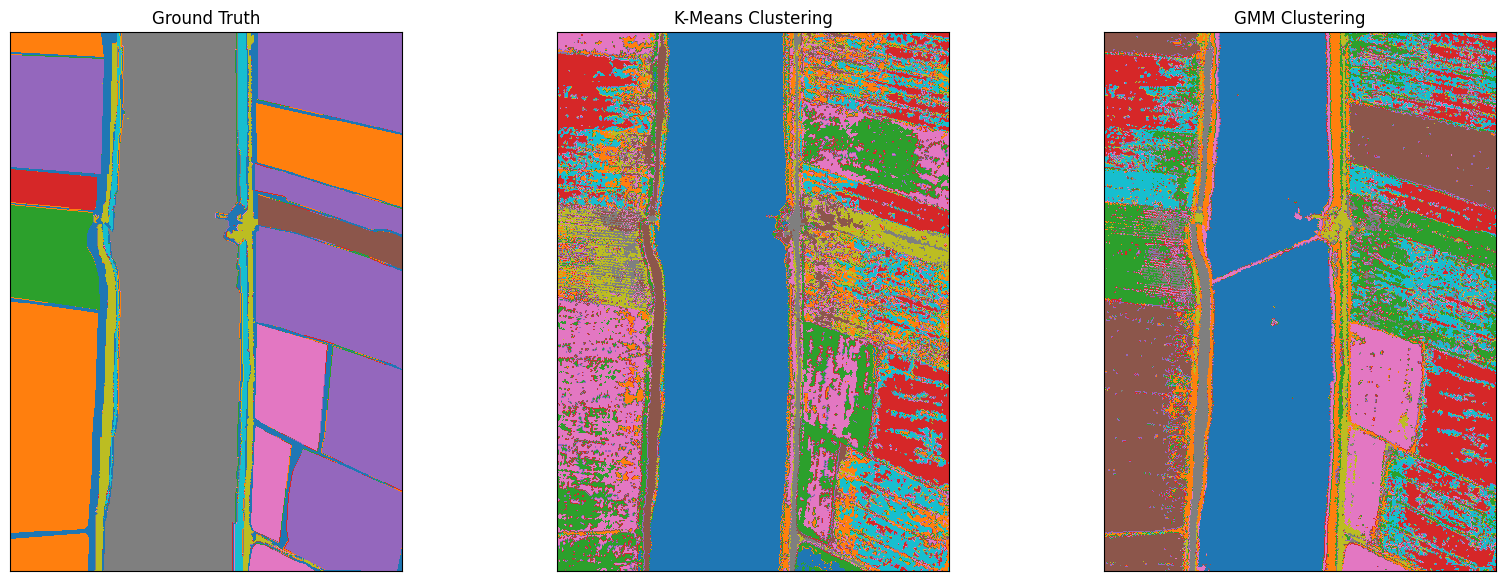

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

# Ground truth
ax[0].imshow(ground_truth, cmap='tab10')
ax[0].set_title('Ground Truth')
ax[0].set_xticks([])
ax[0].set_yticks([])

# K-Means
ax[1].imshow(kmeans_image, cmap='tab10')
ax[1].set_title('K-Means Clustering')
ax[1].set_xticks([])
ax[1].set_yticks([])

# GMM
ax[2].imshow(gmm_image, cmap='tab10')
ax[2].set_title('GMM Clustering')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()
